#### Figure 1

In [16]:
# Interquartile range
def get_iqr(dat):
    return np.quantile(dat, 0.75) - np.quantile(dat, 0.25)

# Silverman bandwidth estimate
def silverman(dat):
    return 0.9 * np.min([np.std(dat), get_iqr(dat)/1.34]) * len(dat)**-0.2

In [17]:
##################################################################################################
include_p05 = False ################# If True, only counties with F-test p-value < 0.05 are included
include_loo = True ################# If True, only counties with LOO CV improvement are included
if include_p05:
    p05_counties = pd.read_csv('../ag_model/fit_model/ag_model_coeff_final.csv').query('pval < 0.05')['GEOID'].astype(str).str.zfill(5).unique()
    weights = weights.loc[p05_counties]
elif include_loo:
    p05_counties = pd.read_csv('../ag_model/fit_model/loo_yes.csv')['GEOID'].astype(str).str.zfill(5).unique()
    weights = weights.loc[p05_counties]
##################################################################################################

# Yield (weighted by production)
nex_weighted = pd.merge(nex_hist.reset_index(), weights.reset_index(), left_on = ['GEOID','Year'], right_on = ['GEOID','year'], how = 'inner').drop(columns = ['year'])
for model in nex_weighted.columns[2:-1]:
    nex_weighted[model] = nex_weighted[model] * nex_weighted['national_weight']
nex_weighted = nex_weighted.groupby(['Year']).sum()

cmip_weighted = pd.merge(cmip_hist.reset_index(), weights.reset_index(), left_on = ['GEOID','Year'], right_on = ['GEOID','year'], how = 'inner').drop(columns = ['year'])
for model in cmip_weighted.columns[2:-1]:
    cmip_weighted[model] = cmip_weighted[model] * cmip_weighted['national_weight']
cmip_weighted = cmip_weighted.groupby(['Year']).sum()

# Ensembles
NEXens_w = nex_weighted.drop(columns = ['GMFD', 'national_weight']).to_numpy().flatten()
CMIPens_w = cmip_weighted.drop(columns = ['GMFD', 'national_weight']).to_numpy().flatten()
GMFDens_w = nex_weighted.filter(['GMFD']).to_numpy().flatten()

In [18]:
%%time
# Construct CDFs
nexgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(NEXens_w), 3*silverman(NEXens_w), 30)})
cmipgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(CMIPens_w), 3*silverman(CMIPens_w), 30)})
nexgrid.fit(NEXens_w[:, None])
cmipgrid.fit(CMIPens_w[:, None])
print(nexgrid.best_params_['bandwidth'])
print(cmipgrid.best_params_['bandwidth'])
NEX_ens_pdf = KernelDensity(bandwidth=nexgrid.best_params_['bandwidth'])
NEX_ens_pdf.fit(NEXens_w[:, np.newaxis]);
CMIP_ens_pdf = KernelDensity(bandwidth=cmipgrid.best_params_['bandwidth'])
CMIP_ens_pdf.fit(CMIPens_w[:, np.newaxis]);

0.01909519300964212
0.03568534176614341
CPU times: user 2.3 s, sys: 5.89 ms, total: 2.31 s
Wall time: 2.32 s


KernelDensity(bandwidth=0.03568534176614341)

In [19]:
%%time
sampDist = [NEX_ens_pdf.sample(n_samples = 46).flatten() for i in range(50000)]
CsampDist = [CMIP_ens_pdf.sample(n_samples = 46).flatten() for i in range(50000)]

CPU times: user 3.68 s, sys: 36.1 ms, total: 3.72 s
Wall time: 3.73 s


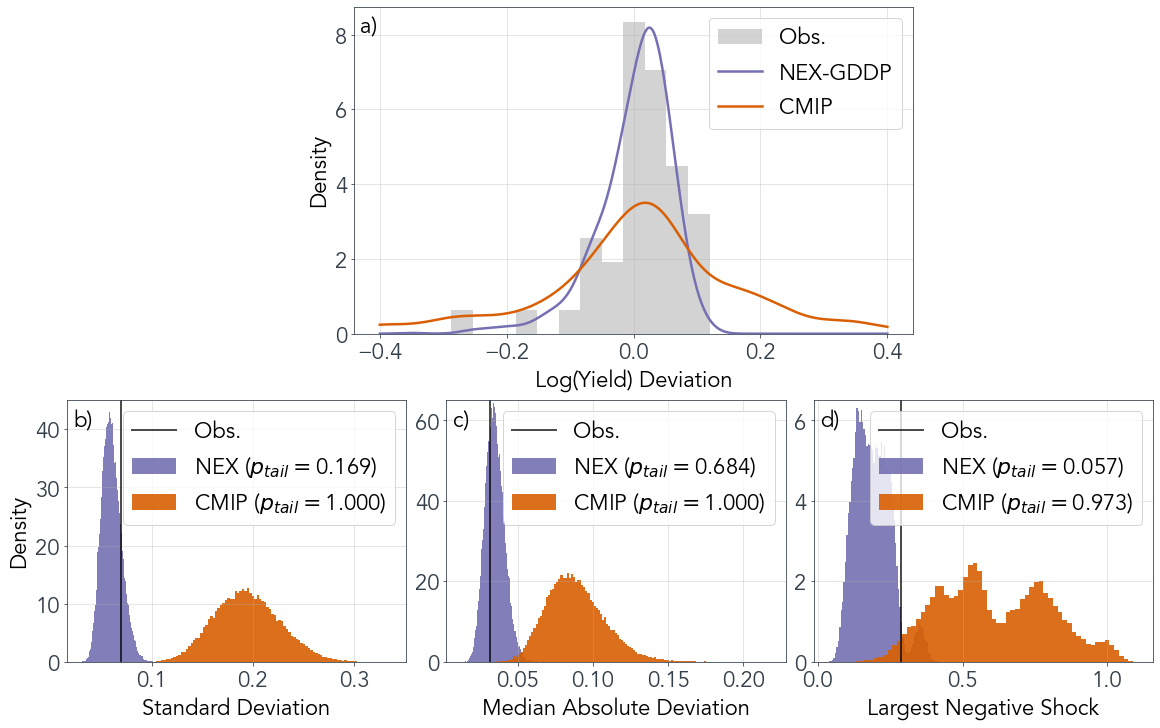

In [31]:
# Final
fig = plt.figure(figsize=(16,10), constrained_layout=True)
gs = gridspec.GridSpec(9, 9, figure=fig)
plt.rcParams['font.size'] = 22

# PDF
ax1 = fig.add_subplot(gs[:5,2:-2])
xarr = np.linspace(-0.4,0.4,1000)
ax1.hist(GMFDens_w, label = 'Obs.', color = 'darkgray', density=True, alpha = 0.5, bins='fd')
ax1.plot(xarr, np.exp(NEX_ens_pdf.score_samples(xarr[:,None])), label = 'NEX-GDDP', color = '#7570b3', linewidth=2.5)
ax1.plot(xarr, np.exp(CMIP_ens_pdf.score_samples(xarr[:,None])), label = 'CMIP', color = '#d95f02', linewidth=2.5)

handles, labels = ax1.get_legend_handles_labels()
order = [2,0,1]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

ax1.set_xlabel('Log(Yield) Deviation')
ax1.set_ylabel('Density')
ax1.text(0.01, 0.92, 'a)', transform=ax1.transAxes)
ax1.grid(zorder=10, alpha=0.4)

# SD
ax2 = fig.add_subplot(gs[-4:, :3])
sampDist1 = np.array([np.std(x) for x in sampDist])
CsampDist1 = np.array([np.std(x) for x in CsampDist])
val = np.std(GMFDens_w)
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax2.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax2.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax2.plot([val,val], [0,80], linewidth=2, color = 'black', label = 'Obs.', alpha=0.7)
ax2.set_xlabel('Standard Deviation')
ax2.set_ylabel('Density')
ax2.text(0.02, 0.9, 'b)', transform=ax2.transAxes)
ax2.legend()
ax2.grid(zorder=10, alpha=0.4)
ax2.set_ylim([0,45])

# MAD
ax3 = fig.add_subplot(gs[-4:, 3:6])
sampDist1 = np.array([ss.median_abs_deviation(x) for x in sampDist])
CsampDist1 = np.array([ss.median_abs_deviation(x) for x in CsampDist])
val = ss.median_abs_deviation(GMFDens_w)
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax3.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax3.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax3.plot([val,val], [0,80], linewidth=2, color = 'black', label = 'Obs.', alpha=0.7)
ax3.set_xlabel('Median Absolute Deviation')
ax3.text(0.02, 0.9, 'c)', transform=ax3.transAxes)
ax3.legend()
ax3.grid(zorder=10, alpha=0.4)
ax3.set_ylim([0,65])

# Min
ax4 = fig.add_subplot(gs[-4:, 6:])
sampDist1 = np.array([np.abs(np.min(x)) for x in sampDist])
CsampDist1 = np.array([np.abs(np.min(x)) for x in CsampDist])
val = np.abs(np.min(GMFDens_w))
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax4.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax4.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax4.plot([val,val], [0,10], linewidth=2, color = 'black', label = 'Obs.', alpha=0.7)
ax4.set_xlabel('Largest Negative Shock')
ax4.text(0.02, 0.9, 'd)', transform=ax4.transAxes)
ax4.legend()
ax4.set_xticks([0.0,0.5,1.0])
ax4.grid(zorder=0, alpha=0.4)
ax4.set_ylim([0,6.5])

# Save
# plt.show()
plt.savefig('../figs/figure1.pdf')